# Probando con nuevas imagenes

Realizamos los imports correspondientes

In [80]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage import io, feature
from skimage.transform import rescale
from skimage.color import rgb2gray
import windows

Cargamos los clasificadores:

In [81]:
import pickle

path = '..//rsc//obj//'

# Todas las rutas
svm_path = path + 'svm_clf.sav'
svm2_path = path + 'svm2_clf.sav'
gtb_path = path + 'gtb_clf.sav'
rf_path = path + 'rf_clf.sav'

# Serizalización
svm_clf = pickle.load(open(svm_path, 'rb'))
svm2_clf = pickle.load(open(svm2_path, 'rb'))
gtb_clf = pickle.load(open(gtb_path, 'rb'))
rf_clf = pickle.load(open(rf_path, 'rb'))

classifiers = [#svm_clf, 
               svm2_clf, 
               #gtb_clf, 
               #rf_clf
]

Cargamos las imagenes

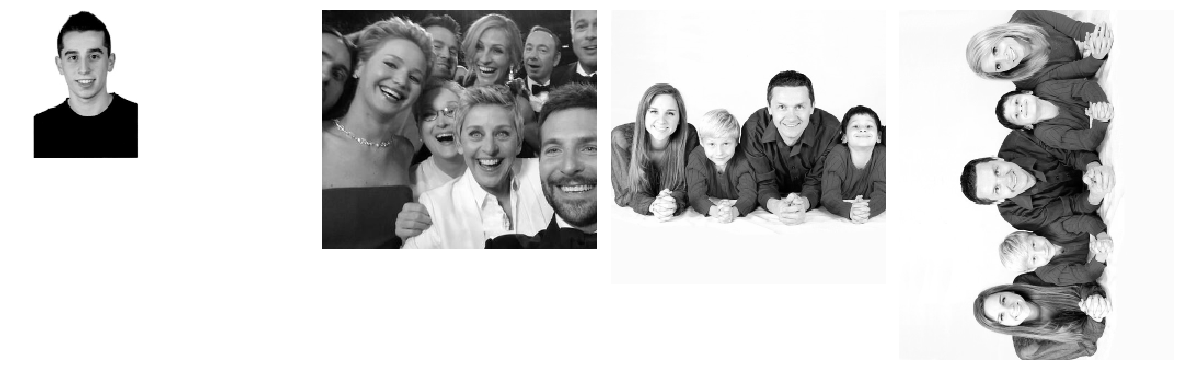

In [82]:
img1 = io.imread("..\\rsc\\img\\my_face.jpg")
img2 = io.imread("..\\rsc\\img\\faces_test.jpg")
img3 = io.imread("..\\rsc\\img\\family.jpg")
img4 = io.imread("..\\rsc\\img\\rotated_family.jpg")

imgs = [img1, img2, img3, img4]
rescale_list = [0.3, 0.65, 0.5, 0.5]

# Convertimos imagen a escala de grises
for index in range(len(imgs)):
    imgs[index] = rgb2gray(imgs[index])
    imgs[index] = rescale(imgs[index], rescale_list[index])

# Rotamos la ultima imagen 90 grados
img4 = rgb2gray(img4)
img4 = rescale(img4, 0.5)

# Mostramos la imagen resultante
fig, axes = plt.subplots(ncols=len(imgs), figsize=(16, 5.4), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

for index in range(len(imgs)):
    axes[index].imshow(imgs[index], cmap='gray')
    axes[index].axis('off');

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                    right=1)
plt.show()

Obtenemos las ventanas de nuestras imagenes

In [87]:
all_indices = []
all_patches = []
all_patches_hog = []

for index in range(len(imgs)):
    indices, patches = zip(*sliding_window(imgs[index]))
    all_indices.append(np.array(indices))
    all_patches.append(patches)
    all_patches_hog.append(np.array([feature.hog(patch) for patch in patches]))

Enviamos a nuestros clasificadores las distintas ventanas o porciones de las imagenes:

In [88]:
labels = []
for i in range(len(classifiers)):
    for j in range(len(imgs)):
        if i != 0 and i != 1:
            labels.append(classifiers[i].predict_proba(all_patches_hog[j])[:,1])
        else:
            labels.append(classifiers[i].predict(all_patches_hog[j]))

Mostramos los resultados obtenidos:

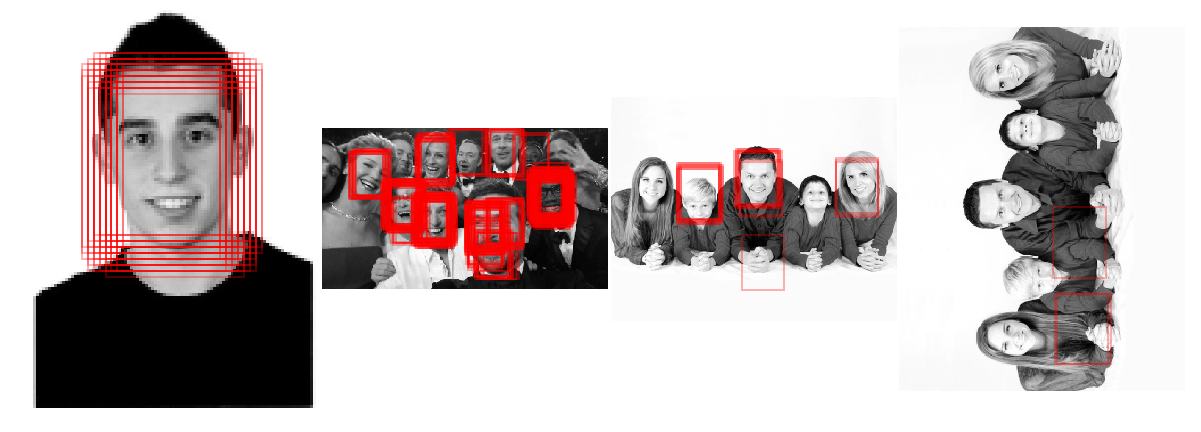

In [89]:
# Mostramos las imagenes resultante
fig, axes = plt.subplots(nrows=len(classifiers), ncols=len(imgs), 
                         figsize=(16, 10.4),# sharex=True, sharey=True, 
                         subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()

k = 0
all_boxes = list()
for clf_index in range(len(classifiers)):
    for img_index in range(len(imgs)):
        
        axes[k].imshow(imgs[img_index], cmap='gray')
        axes[k].axis('off')

        Ni, Nj = positive_patches[0].shape
        
        indices = all_indices[img_index]

        boxes = list()
        for i, j in indices[labels[k] > 0.95]:
            boxes.append((j,i,j+Nj,i+Ni))
            axes[k].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                       alpha=0.3, lw=2, facecolor='none'))
        all_boxes.append(np.array(boxes))
        k += 1

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                     right=1)
plt.show()

Y finalmente eliminamos las ventanas redudantes, intentando conservar : 

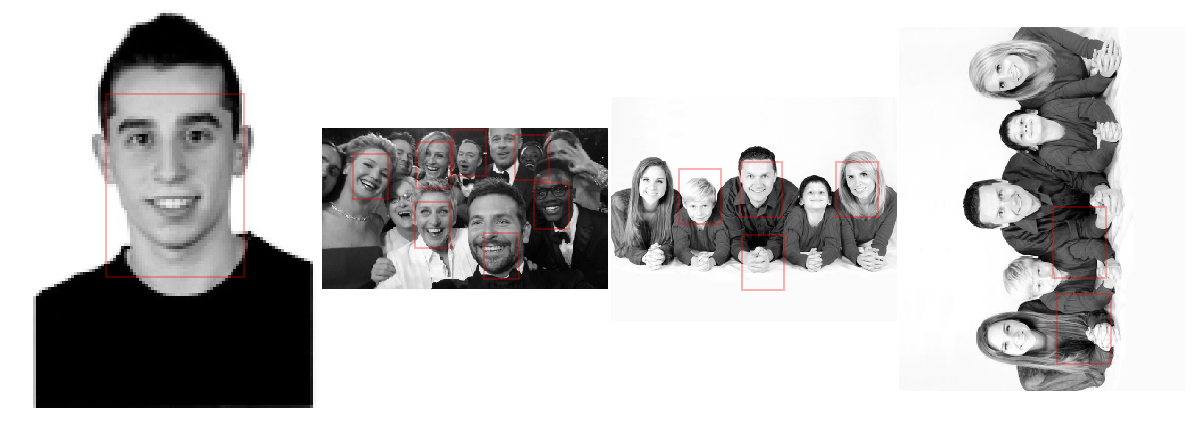

In [90]:
# Mostramos las imagenes resultantes
fig, axes = plt.subplots(nrows=len(classifiers), ncols=len(imgs), 
                         figsize=(16, 10), #sharex=True, sharey=True, 
                         subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()

k = 0
for clf_index in range(len(classifiers)):
    for imgs_index in range(len(imgs)):
        image = imgs[imgs_index]
        boundingBoxes = all_boxes[k]
        
        # perform non-maximum suppression on the bounding boxes
        pick = non_max_suppression_fast(boundingBoxes, 0.01)
        
        axes[k].imshow(image, cmap='gray')
        axes[k].axis('off')
        
        
        for (i, j, _, _) in pick:
            #print(i, j, Ni, Nj)
            axes[k].add_patch(plt.Rectangle((i, j), Nj, Ni, edgecolor='red',
                                            alpha=0.3, lw=2, facecolor='none'))
        k += 1
        
fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                     right=1)
plt.show()